In [1]:
import sys

sys.path.append("..")

In [2]:
from pathlib import Path

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.model_manager import MLPManager
from src.loader import parse_out_data, parse_con_parameter
from src.preprocess import fill_nan_with_interp

In [3]:
def normalize(data):
    """
    Normalize the data to the range [0, 1].
    """
    data_min = np.min(data)
    data_max = np.max(data)
    return (data - data_min) / (data_max - data_min)

In [4]:
model_path = (
    Path("C:\\dev\\science\\xray_reflection\\XRRmaker\\models") / "mlp_model.pth"
)
data_path = Path("C:\\dev\\science\\xray_reflection\\data\\simulation_data2")

X_data = []
y_data = []
for num in tqdm(range(1, 100001), desc="Load"):
    out_file = data_path / f"d{num:05}" / "1.out"
    con_file = data_path / f"d{num:05}" / "1.con"
    data = parse_out_data(out_file)
    x = data[["XOBS", "YCALC"]].values
    x = fill_nan_with_interp(x)
    X_data.append(x)
    y = np.asarray(parse_con_parameter(con_file))  # [[6, 10, 11, 14, 15, 18, 19]]
    y_data.append(y)

X_data = np.stack(X_data, axis=0)
y_data = np.stack(y_data, axis=0)

Load: 100%|██████████| 100000/100000 [18:35<00:00, 89.61it/s]


In [5]:
X_data = normalize(X_data)
y_data = normalize(y_data)

In [6]:
# 테스트 데이터셋 비율 설정
test_size = 0.2

# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=test_size, random_state=42, shuffle=True
)

# 나누어진 데이터셋 형상 확인
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (80000, 314, 2), y_train shape: (80000, 12)
X_test shape: (20000, 314, 2), y_test shape: (20000, 12)


Initialized MLPManager on device: cpu
Epoch 1/25 - Train Loss: 0.0073 - Val Loss: 0.0051
Epoch 2/25 - Train Loss: 0.0051 - Val Loss: 0.0049
Epoch 3/25 - Train Loss: 0.0050 - Val Loss: 0.0049
Epoch 4/25 - Train Loss: 0.0049 - Val Loss: 0.0049
Epoch 5/25 - Train Loss: 0.0049 - Val Loss: 0.0048
Epoch 6/25 - Train Loss: 0.0049 - Val Loss: 0.0048
Epoch 7/25 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 8/25 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 9/25 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 10/25 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 11/25 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 12/25 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 13/25 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 14/25 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 15/25 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 16/25 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 17/25 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 18/25 - Train Loss: 0.0048 - Val Loss: 0.0048
Epoch 19/25 - Train Loss: 0.0048 - 

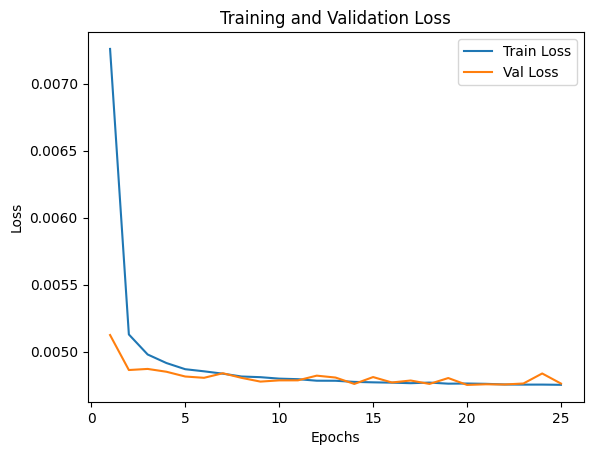

In [12]:
input_dim: int = X_data.shape[1] * X_data.shape[2]
output_dim: int = y_data.shape[1]
manager = MLPManager(input_dim=input_dim, output_dim=output_dim, learning_rate=1e-5)

history = manager.train(
    X_data=X_data,
    y_data=y_data,
    model_path=model_path,
    epochs=25,
    batch_size=64,
    val_ratio=0.1,
)

epochs = range(1, len(history["train_loss"]) + 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [8]:
predictions = manager.predict(X_test, model_path=model_path)

print("Predictions Shape:", predictions.shape)

Model state loaded from C:\dev\science\xray_reflection\XRRmaker\models\mlp_model.pth
Predictions Shape: (20000, 12)


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 모델 평가
# 평균 제곱 오차 (MSE) 계산
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

output_dim_indices = list(range(y_data.shape[1]))
for i, idx in enumerate(output_dim_indices):
    mse_single = mean_squared_error(y_test[:, i], predictions[:, i])
    mae_single = mean_absolute_error(y_test[:, i], predictions[:, i])
    print(f"Output Dim {idx} - MSE: {mse_single:.4f}, MAE: {mae_single:.4f}")

Mean Squared Error (MSE): 0.0047
Mean Absolute Error (MAE): 0.0239
Output Dim 0 - MSE: 0.0000, MAE: 0.0026
Output Dim 1 - MSE: 0.0000, MAE: 0.0028
Output Dim 2 - MSE: 0.0000, MAE: 0.0028
Output Dim 3 - MSE: 0.0000, MAE: 0.0029
Output Dim 4 - MSE: 0.0000, MAE: 0.0035
Output Dim 5 - MSE: 0.0005, MAE: 0.0180
Output Dim 6 - MSE: 0.0000, MAE: 0.0036
Output Dim 7 - MSE: 0.0000, MAE: 0.0024
Output Dim 8 - MSE: 0.0005, MAE: 0.0187
Output Dim 9 - MSE: 0.0005, MAE: 0.0186
Output Dim 10 - MSE: 0.0003, MAE: 0.0142
Output Dim 11 - MSE: 0.0547, MAE: 0.1972
